In [1]:
# Современные методы вычислительной математики и механики, 1 семестр, 2021 г.
# Лабораторная работа 2. Методы решения бигармонических уравнений: Метод КНК.
# Решение задачи через глобальную СЛАУ.
###########################
import numpy as np
import scipy as sp
import math
from matplotlib import  pyplot as plt
import copy

#Базис: Chebyshev или Monoms
Basis = 'Chebyshev'
N_degree = 4 # степень аппроксимирующего полинома
N_colloc = N_degree + 1 # количество точек коллокации
N_eq = N_colloc + 4 # Количество уравнений в локальной матрице

X0 = 0.0
X1 = 1.0
if(Basis == 'Monoms'):
    y_ = np.linspace(-1., 1., N_colloc+2, endpoint = True)
if(Basis == 'Chebyshev'):
    y_ = np.array([-np.cos(i / (N_colloc+1) * np.pi) for i in range(0, N_colloc+2)])


In [2]:
# функция нагрузки 
def f(x):
    return np.exp(x)
    #return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*np.exp(x)

# Точное решение
def u_exact(x):
    u = np.exp(x)
    #u = x**2*(1-x)**2*math.exp(x)  
    return u

def boundary_func(x):
    #return 0
    return u_exact(x)

def der_boundary_func(x):
    #return 0
    return np.exp(x)

def polynomial(degree, y):
    if(Basis == 'Monoms'):
        return y**degree
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 1
        elif(degree == 1):
            return y
        else:
            return 2*y*polynomial(degree - 1, y) - polynomial(degree - 2, y)

def der1_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 1):
            return degree*y**(degree - 1)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 1
        else:
            return 2*y*der1_polynomial(degree - 1, y) - der1_polynomial(degree - 2, y) + 2*polynomial(degree - 1, y)

def der2_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 2):
            return degree*(degree - 1) * y**(degree - 2)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der2_polynomial(degree - 1, y) - der2_polynomial(degree - 2, y) + 2*2*der1_polynomial(degree - 1, y)

def der3_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 3):
            return degree*(degree - 1) * (degree - 2) * y**(degree - 3)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der3_polynomial(degree - 1, y) - der3_polynomial(degree - 2, y) + 2*3*der2_polynomial(degree - 1, y)

def der4_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 4):
            return degree*(degree - 1) *(degree - 2)*(degree - 3)* y**(degree - 4)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der4_polynomial(degree - 1, y) - der4_polynomial(degree - 2, y) + 2*4*der3_polynomial(degree - 1, y)

# Вычисление решения по найденным коэффициентам
def u(x, Matrix, GlobalNodes):
    # переход в локальную систему  
    h = (GlobalNodes[1] - GlobalNodes[0])/2
    
    if (x == X0):
        cell_id = 0
    elif (x == X1):
        cell_id = len(GlobalNodes) - 2
    else:
        cell_id = int(x // (2*h)) 

    x_c = (GlobalNodes[cell_id] + GlobalNodes[cell_id+1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([Matrix[cell_id, i]*polynomial(i, y) for i in range(N_degree+1)])
    return ans

In [3]:
def set_Global_Matrix(N_cells, GlobalNodes):
    GlobalMatrix = np.zeros((N_eq*N_cells, (N_degree + 1) * N_cells))
    GlobalVector = np.zeros(N_eq*N_cells)

    step = GlobalNodes[1] - GlobalNodes[0]
    
    #Уравнения в левой ячейке
    # граничные условия
    GlobalMatrix[0, 0:N_degree+1] = [polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalMatrix[1, 0:N_degree+1] = [der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalVector[0] = boundary_func(X0)
    GlobalVector[1] = (step/2)*der_boundary_func(X0)

    # условия согласования
    GlobalMatrix[N_eq-2, 0:N_degree+1] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 0:N_degree+1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalVector[N_eq-2] = 0
    GlobalVector[N_eq-1] = 0
    GlobalMatrix[N_eq-2, 1*(N_degree+1): 2*(N_degree+1)] = [-(polynomial(j, y_[0]) + der1_polynomial(j, y_[0]))  for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 1*(N_degree+1): 2*(N_degree+1)] = [- (der2_polynomial(j, y_[0]) + der3_polynomial(j, y_[0]))  for j in range(N_degree+1)]

    # условия коллокации
    xc = (GlobalNodes[0] + GlobalNodes[1])/2
    x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
    for i in range(2, N_colloc+2):
        GlobalMatrix[i][4:N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        # правая часть в точках коллокации  
    GlobalVector[2: N_colloc+2] = (step/2)**4*f(x)

    #Уравнения в правой ячейке
    index = (N_cells-1)*N_eq 
    index_row  = (N_cells-1)*(N_degree+1)
    #условия согласования
    GlobalMatrix[index, index_row + 0: index_row + N_degree+1] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row + 0: index_row + N_degree+1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
    GlobalVector[index + 0] = 0
    GlobalVector[index + 1] = 0
    GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-(polynomial(j, y_[-1]) - der1_polynomial(j, y_[-1]))  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- (der2_polynomial(j, y_[-1]) - der3_polynomial(j, y_[-1]))  for j in range(N_degree+1)]

    # краевые условия
    GlobalMatrix[index + N_eq-2, index_row + 0: index_row + N_degree+1] = [polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalMatrix[index + N_eq-1, index_row + 0: index_row + N_degree+1] = [der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    GlobalVector[index + N_eq-2] = boundary_func(X1)
    GlobalVector[index + N_eq-1] = (step/2) * der_boundary_func(X1)

    step = GlobalNodes[1] - GlobalNodes[0]
    # условия коллокации
    xc = (GlobalNodes[N_cells - 1] + GlobalNodes[N_cells])/2
    x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
    for i in range(2, N_colloc+2):
        GlobalMatrix[index + i][index_row + 4:index_row + N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        # правая часть в точках коллокации  
    GlobalVector[index + 2:index + N_colloc + 2] = (step/2)**4*f(x)

    #Уравнения во внутренних ячейках 
    for i_cell in range(1, N_cells - 1):
        index = (i_cell)*N_eq 
        index_row  = (i_cell)*(N_degree+1)

        # условия согласования
        GlobalMatrix[index, index_row + 0 : index_row + N_degree+1] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
        GlobalMatrix[index + 1, index_row + 0 : index_row + N_degree+1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
        GlobalVector[index + 0] = 0
        GlobalVector[index + 1] = 0
        GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-(polynomial(j, y_[-1]) - der1_polynomial(j, y_[-1]))  for j in range(N_degree+1)]
        GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- (der2_polynomial(j, y_[-1]) - der3_polynomial(j, y_[-1]))  for j in range(N_degree+1)]


        # условия согласования
        GlobalMatrix[index + N_eq-2, index_row + 0 : index_row + N_degree+1] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1])  for j in range(N_degree+1)]
        GlobalMatrix[index + N_eq-1, index_row + 0 : index_row + N_degree+1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1])  for j in range(N_degree+1)]
        GlobalVector[index + N_eq-2] = 0
        GlobalVector[index + N_eq-1] = 0
        GlobalMatrix[index + N_eq-2, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [-(polynomial(j, y_[0]) + der1_polynomial(j, y_[0]))  for j in range(N_degree+1)]
        GlobalMatrix[index + N_eq-1, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [- (der2_polynomial(j, y_[0]) + der3_polynomial(j, y_[0]))  for j in range(N_degree+1)]

        step = GlobalNodes[1] - GlobalNodes[0]
        # условия коллокаций
        # правая часть в точках коллокации  
        xc = (GlobalNodes[i_cell] + GlobalNodes[i_cell + 1])/2
        x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
        for i in range(2, N_colloc+2):
            GlobalMatrix[index + i][index_row + 4:index_row + N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
        GlobalVector[index + 2:index + N_colloc + 2] = (step/2)**4*f(x)
    return GlobalMatrix, GlobalVector


In [4]:
def Global_matrix_solution(N_cells):
    step = (X1-X0)/N_cells
    # Создаем массив узлов (границы ячеек) 
    GlobalNodes = np.linspace(X0,X1, N_cells+1, endpoint = True) 

    GlobalMatrix, GlobalVector = set_Global_Matrix(N_cells, GlobalNodes)

    Q, R = np.linalg.qr(GlobalMatrix)
    ans = np.dot(np.linalg.inv(R), np.dot(Q.T, GlobalVector)) 

    CoeffMatrix = np.zeros((N_cells, N_degree + 1))

    for i in range(N_cells):
        CoeffMatrix[i] = ans[i*(N_degree + 1):(i+1)*(N_degree + 1)]

    Cond_A = np.linalg.cond(GlobalMatrix)
    
    return CoeffMatrix, GlobalNodes, Cond_A, GlobalMatrix, GlobalVector    

# Отрисовка решения
def plot_solution(Solution):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    X_cor = np.arange(X0, X1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, Solution[0], Solution[1]) for i in X_cor])
    # значение точного решения на сетке
    u_ex = np.array([u_exact(i) for i in X_cor])
    # рисуем численное решение
    plt.plot(X_cor, u_, 'r-', label ='num')
    # рисуем точное решение
    plt.plot(X_cor, u_ex, 'b--', label = 'exact')
    plt.legend()

Time in seconds: 0.015002727508544922
5
Time in seconds: 0.02300119400024414
10
Time in seconds: 0.03499794006347656
20
Time in seconds: 0.09299659729003906
40
Time in seconds: 0.45399999618530273
80
Time in seconds: 1.462000846862793
160


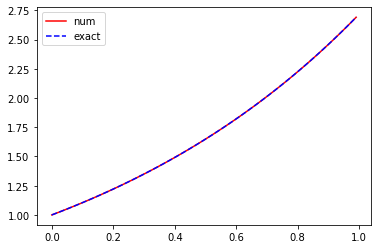

In [5]:
import time
# решаем задачу на последовательности сеток, начиная с 5

i=5
Solution_array = [  ]
error = []
error_abs = []
X_cor = np.linspace(X0, X1, 100)
u_ex = np.array([u_exact(i) for i in X_cor])

# засекаем время
start = time.time() 
cur_time = start       
while i < 161:
    # решаем задачу
    ans = Global_matrix_solution(i)
    print("Time in seconds:", time.time()-cur_time)
    cur_time = time.time()
    # сохраняем решение в массив решений
    Solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(x, ans[0], ans[1]) for x in X_cor])
    # вычисляем относительную погрешность
    error_abs.append(np.max(abs(u_-u_ex)))  
    error.append(np.max(abs(u_-u_ex))/np.max(abs(u_ex)))  
    print(i)
    i=i*2
# отрисовка последнего решения (можно поменять на любое из массива решений)
plot_solution(Solution_array[-1])

In [6]:
# импортируем утилиту для отрисовки красивых таблиц
# для установки в коммандной строке прописать: pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Mesh", "Error_absolute", "Order abs", "Error_relative", "Order", "Cond_Global_matrix"]

rate = [0]
rate_abs = [0]
for i in range(len(error)-1):
    rate.append(np.log2(error[i]/error[i+1]))
    rate_abs.append(np.log2(error_abs[i]/error_abs[i+1]))
for i in range(len(error)):
    x.add_row([5*2**(i), "{:2.2e}".format(error_abs[i]), "{:2.2e}".format(rate_abs[i]), "{:2.2e}".format(error[i]), "{:2.2e}".format(rate[i]), "{:2.2e}".format(Solution_array[i][2])])
print(x)

+------+----------------+-----------+----------------+----------+--------------------+
| Mesh | Error_absolute | Order abs | Error_relative |  Order   | Cond_Global_matrix |
+------+----------------+-----------+----------------+----------+--------------------+
|  5   |    1.65e-05    |  0.00e+00 |    6.06e-06    | 0.00e+00 |      8.34e+03      |
|  10  |    4.04e-06    |  2.03e+00 |    1.49e-06    | 2.03e+00 |      1.27e+05      |
|  20  |    1.00e-06    |  2.01e+00 |    3.69e-07    | 2.01e+00 |      2.02e+06      |
|  40  |    2.51e-07    |  2.00e+00 |    9.22e-08    | 2.00e+00 |      3.24e+07      |
|  80  |    6.27e-08    |  2.00e+00 |    2.31e-08    | 2.00e+00 |      5.18e+08      |
| 160  |    1.75e-08    |  1.84e+00 |    6.43e-09    | 1.84e+00 |      8.28e+09      |
+------+----------------+-----------+----------------+----------+--------------------+
